In [ ]:
# Import necessary libraries for data processing, model building, and visualization
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier

import numpy as np
import os, cv2

In [ ]:
# Function to plot images in a gallery format
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    fig.add_subplot(n_row, n_col, i+1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())
  plt.show()

In [ ]:
#Mounting Google Drive to the Colab environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the directory containing face images
dir_name = "/content/drive/MyDrive/FaceRecognition/dataset/faces"
y = []
x = []
target_names = []
person_id = 0
h = w = 300
n_samples=0
class_names = []
# Loop through each person's directory and process their images
for person_name in os.listdir(dir_name):
  dir_path = dir_name + "/" + person_name + "/"
  class_names.append(person_name)

  for img_name in os.listdir(dir_path):
    image_path = dir_path + img_name
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(gray, (h, w))
    v = resize_img.flatten()
    x.append(v)
    n_samples = n_samples+1
    y.append(person_id)
    target_names.append(person_name)
  person_id = person_id+1

In [ ]:
# Convert data to numpy arrays for processing
y = np.array(y)
x = np.array(x)
target_names = np.array(target_names)
n_features = x.shape[1]
print(y.shape,x.shape,target_names.shape)
print("Number of samples: ",n_samples)

(450,) (450, 90000) (450,)
Number of samples:  450


In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=25,random_state=42)

# Define the number of eigenfaces to extract
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, x_train.shape[0]))

Extracting the top 150 eigenfaces from 425 faces


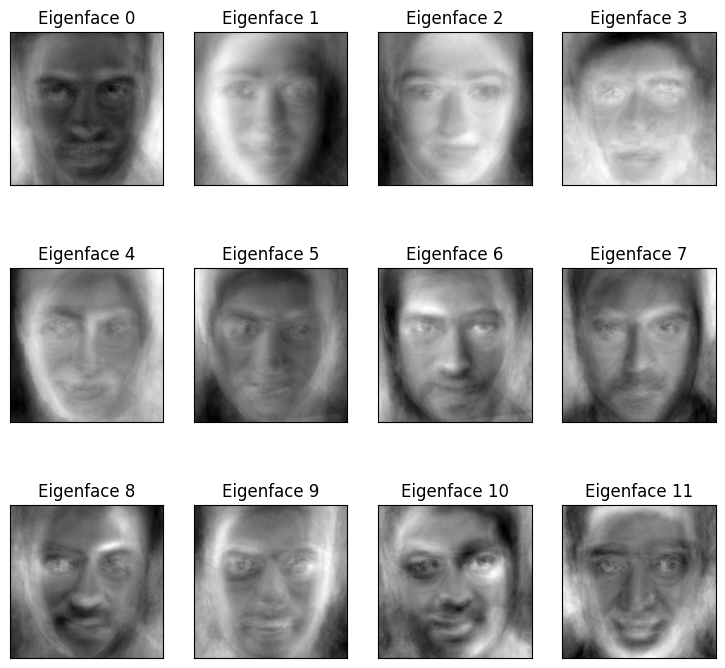

Projeceting the input data on the eigenfaces principle components
(425, 150) (25, 150)
Project done...


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=n_components,svd_solver = "randomized",whiten=True).fit(x_train)

# Get the eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# Generate titles for eigenfaces
eigenfaces_titles = ["Eigenface %d" % i for i in range(n_components)]
plot_gallery(eigenfaces, eigenfaces_titles, h, w)
plt.show()

# Project the training and testing data onto the eigenfaces
print("Projeceting the input data on the eigenfaces principle components")
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape,x_test_pca.shape)

# Apply LDA for further classification
lda = LDA()
lda.fit(x_train_pca,y_train)
x_train_lda = lda.transform(x_train_pca)
x_test_lda = lda.transform(x_test_pca)
print("Project done...")

In [ ]:
# Train a multi-layer perceptron classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose = True).fit(x_train_lda, y_train)
print("Model weight:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.44005250
Iteration 2, loss = 2.07970068
Iteration 3, loss = 1.77450454
Iteration 4, loss = 1.50409397
Iteration 5, loss = 1.27268242
Iteration 6, loss = 1.07761207
Iteration 7, loss = 0.91139012
Iteration 8, loss = 0.77180951
Iteration 9, loss = 0.65573692
Iteration 10, loss = 0.55531856
Iteration 11, loss = 0.47249006
Iteration 12, loss = 0.40387658
Iteration 13, loss = 0.34564915
Iteration 14, loss = 0.29847591
Iteration 15, loss = 0.25958371
Iteration 16, loss = 0.22813509
Iteration 17, loss = 0.20263872
Iteration 18, loss = 0.18206475
Iteration 19, loss = 0.16544816
Iteration 20, loss = 0.15135721
Iteration 21, loss = 0.13953556
Iteration 22, loss = 0.12978671
Iteration 23, loss = 0.12108252
Iteration 24, loss = 0.11369320
Iteration 25, loss = 0.10728714
Iteration 26, loss = 0.10143319
Iteration 27, loss = 0.09648243
Iteration 28, loss = 0.09186117
Iteration 29, loss = 0.08767732
Iteration 30, loss = 0.08422972
Iteration 31, loss = 0.08063404
Iteration 32, los

Accuracy:  80.0


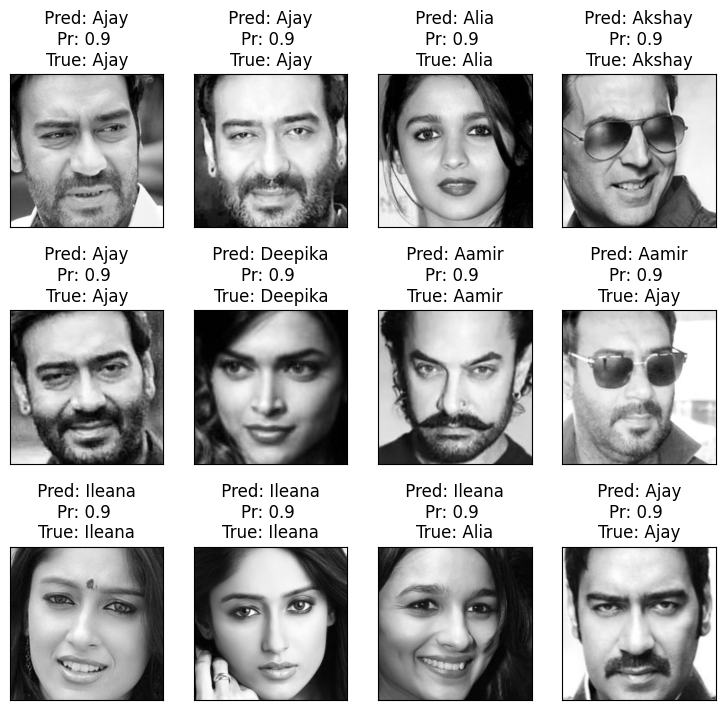

In [ ]:
# Predict classes for the test data
y_pred = []
y_proba = []
for test_face in x_test_lda:
  prob = clf.predict_proba([test_face])[0]
  class_id = np.where(prob == np.max(prob))[0][0]
  y_pred.append(class_id)
  y_proba.append(np.max(prob))
y_pred = np.array(y_pred)

# Calculate accuracy and generate titles for the predicted results
pred_titles = []
true_positive = 0
for i in range(y_pred.shape[0]):
  true_name = class_names[y_test[i]]
  pred_name = class_names[y_pred[i]]
  result = " Pred: %s \nPr: %s \nTrue: %s" % ( pred_name, str(y_proba[i])[0:3], true_name)
  pred_titles.append(result)
  if true_name == pred_name:
    true_positive = true_positive+1

# Print the accuracy
print("Accuracy: ",true_positive*100/y_pred.shape[0])

# Plot the predicted results
plot_gallery(x_test, pred_titles, h, w)
plt.show()